## Initial Setup

In [ ]:
from syft.grid.client.client import connect # Method used to connect with the domain.
from syft.grid.client.grid_connection import GridHTTPConnection # Protocol used to talk with the domain

import syft as sy
import torch as th

# Set logging level
import logging
logging.basicConfig(level=logging.INFO)

### Create User Account

In [ ]:
unauthenticated_client = connect(
    url="http://localhost:5000",
    conn_type=GridHTTPConnection
)

unauthenticated_client.users.create(email="scientist@researchorg.edu", password="pwd123")

### Log in as Data Scientist

In [ ]:
domain_client = connect(
    url="http://localhost:5000",
    credentials={"email":"scientist@researchorg.edu", "password":"pwd123"},
    conn_type=GridHTTPConnection
)

### Find a Dataset

In [ ]:
domain_client.datasets.all(pandas=True)

In [ ]:
remote_dataset = domain_client.datasets[""]

In [ ]:
print(remote_dataset.manifest)

In [ ]:
remote_dataset.pandas

### Load Pre-trained Model

epoch 0	loss : 0.7092297673225403	 accuracy : 0.3005
epoch 50	loss : 0.5071974992752075	 accuracy : 0.7825
epoch 100	loss : 0.48725202679634094	 accuracy : 0.7905
epoch 150	loss : 0.47507500648498535	 accuracy : 0.7995
epoch 200	loss : 0.46798834204673767	 accuracy : 0.811
epoch 250	loss : 0.4574986696243286	 accuracy : 0.819


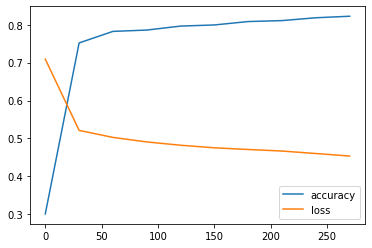

In [1]:
import torch as th
from diabetes_model_training import train_diabetes_model, plot_training_acc
model, loss, acc, epochs_list = train_diabetes_model(th)
plot_training_acc(acc, loss, epochs_list)

### Create a Worker

In [ ]:
domain_client.workers.instance_type(pandas=True)

In [ ]:
domain_client.workers.create(instance_type="Standard_B2s")

In [ ]:
domain_client.workers.all(pandas=True)

In [ ]:
worker = domain_client.workers[1]

### Send the Model to the Worker

In [ ]:
remote_model = model.send(worker)

### Load the Dataset into the Worker

In [ ]:
domain_client.load(remote_dataset.files[0].pointer, worker.address)

In [ ]:
worker.store.pandas

### Perform remote inference

In [ ]:
feature = worker.store[0][0:,0:8]
labels = worker.store[0][0:,8]

predicted = remote_model(feature)

### Add DP noise to the evaluation result

In [ ]:
acc = (predicted.reshape(-1).round() == labels).int().tolist()

In [ ]:
import pydp
sy.load("pydp")

In [ ]:
BoundedMean = worker.pydp.algorithms.laplacian.BoundedMean
mean_ptr = BoundedMean(0.8, lower_bound=0.01, upper_bound=1.0, dtype="float")

acc_result = mean_ptr.quick_result(acc)

### Save the result to the Domain

In [ ]:
worker.save(acc_result)

### Request to download the result

In [ ]:
domain_client.store.pandas

In [ ]:
acc_ptr = domain_client.store['']

In [ ]:
acc_ptr.request(reason="I'd like to have access to my accuracy result!")

### Download the result

In [ ]:
acc_ptr.get()